# Chicago Crime Analysis with PySpark

#### Goals


Some goals for this project:
- Do some simple EDA on *Chicago Crime* from [Kaggle](https://www.kaggle.com/)

All this will be done using **[PySpark](https://spark.apache.org/docs/latest/api/python/)**

<hr>

#### Import Libraries

In [37]:
try:
    from pyspark.sql import SparkSession
    from pyspark import SparkContext
    from pyspark.sql import SQLContext
    from pyspark.sql import DataFrame
    import pyspark.sql.types as tp
    import pyspark.sql.functions as F
    import pandas as pd
    import numpy as np
    import glob
    from functools import reduce
    import seaborn as sns
    import matplotlib.pyplot as plt
    from urllib.request import urlopen
    
    print('[SUCCESS]')
except ImportError as ie:
    raise ImportError(f'[Error importing]: {ie}')

[SUCCESS]


**INITIALIZE SESSION**

In [2]:
sc = SparkContext('local')
spark = SparkSession(sc)

<hr>

#### Read in our DATA

In [3]:
'''
URL THAT WE ARE USING TO READ IN OUR JSON DATA
'''
URL = 'https://data.cityofchicago.org/resource/x2n5-8w5q.json'

In [4]:
def read_json_api(URL):
    json_data = urlopen(URL).read().decode('utf-8')
    
    rdd = spark.sparkContext.parallelize([json_data])
    
    df = spark.read.json(rdd)
    
    
    return df

In [5]:
df = read_json_api(URL)
df.show(5)

+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+-----+---------------------+--------------------+----------------------+------+----+-------------------+--------+--------------------+--------+------+------------+--------------------+-------------+----+------------+------------+
|:@computed_region_43wa_7qmu|:@computed_region_6mkv_f3dw|:@computed_region_awaf_s7ux|:@computed_region_bdys_3d7i|:@computed_region_rpca_8um6|:@computed_region_vrxf_vc4k|_iucr|_location_description|_primary_decsription|_secondary_description|arrest|beat|              block|   case_|  date_of_occurrence|domestic|fbi_cd|    latitude|            location|    longitude|ward|x_coordinate|y_coordinate|
+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+-----+---------------------+-----

<hr>

#### Look at our Schema

Looking at schema allows us to see how our column types are set up.

In [6]:
df.printSchema()

root
 |-- :@computed_region_43wa_7qmu: string (nullable = true)
 |-- :@computed_region_6mkv_f3dw: string (nullable = true)
 |-- :@computed_region_awaf_s7ux: string (nullable = true)
 |-- :@computed_region_bdys_3d7i: string (nullable = true)
 |-- :@computed_region_rpca_8um6: string (nullable = true)
 |-- :@computed_region_vrxf_vc4k: string (nullable = true)
 |-- _iucr: string (nullable = true)
 |-- _location_description: string (nullable = true)
 |-- _primary_decsription: string (nullable = true)
 |-- _secondary_description: string (nullable = true)
 |-- arrest: string (nullable = true)
 |-- beat: string (nullable = true)
 |-- block: string (nullable = true)
 |-- case_: string (nullable = true)
 |-- date_of_occurrence: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- fbi_cd: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- location: struct (nullable = true)
 |    |-- human_address: string (nullable = true)
 |    |-- latitude: string (nullable = 

As we, our schema isn't in the best condition to use for EDA. 

We want certain attributes to the appropriate data types. 
- This would involve changing the schema


However, for now we will stick with the way it is and drop columns we don't need.

In [7]:
columns_to_be_dropped = (':@computed_region_43wa_7qmu', ':@computed_region_6mkv_f3dw', ':@computed_region_awaf_s7ux', ':@computed_region_bdys_3d7i', ':@computed_region_rpca_8um6', ':@computed_region_vrxf_vc4k')

In [8]:
def drop_cols(df, cols):
    df = df.drop(*cols)
    
    return df

In [9]:
df = drop_cols(df, columns_to_be_dropped)
df.printSchema()

root
 |-- _iucr: string (nullable = true)
 |-- _location_description: string (nullable = true)
 |-- _primary_decsription: string (nullable = true)
 |-- _secondary_description: string (nullable = true)
 |-- arrest: string (nullable = true)
 |-- beat: string (nullable = true)
 |-- block: string (nullable = true)
 |-- case_: string (nullable = true)
 |-- date_of_occurrence: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- fbi_cd: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- location: struct (nullable = true)
 |    |-- human_address: string (nullable = true)
 |    |-- latitude: string (nullable = true)
 |    |-- longitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- x_coordinate: string (nullable = true)
 |-- y_coordinate: string (nullable = true)



In [10]:
df.columns

['_iucr',
 '_location_description',
 '_primary_decsription',
 '_secondary_description',
 'arrest',
 'beat',
 'block',
 'case_',
 'date_of_occurrence',
 'domestic',
 'fbi_cd',
 'latitude',
 'location',
 'longitude',
 'ward',
 'x_coordinate',
 'y_coordinate']

Now that we have the columns we want to work with, here is a small description of what each column is according to [chicago.gov](https://www.chicago.gov/city/en/dataset/crime.html)

As we can see, there is a _ at the beginning of our column names, lets change that so it is easier to use when we do EDA.

The parameters to pass in to this function is just the dataframe. We also don't have to pass the column names as this can be stated explicitly since each time this notebook is ran, the data comes from an API.

In [20]:
def rename_cols(df):
    return df.withColumnRenamed('_iucr', 
                                'iucr'
                               ).withColumnRenamed(
                                '_location_description', 
                                'location_description'
                                ).withColumnRenamed(
                                '_primary_decsription',
                                'primary_description'
                                ).withColumnRenamed(
                                '_secondary_description',
                                'secondary_description'
                                ).withColumnRenamed(
                                'case_',
                                'case'
                                ).withColumnRenamed(
                                'date_of_occurrence',
                                'date')
    

In [23]:
df_renamed = rename_cols(df)



# LETS CHECK OUR NEW COLUMN NAMES
df_renamed.columns

['iucr',
 'location_description',
 'primary_description',
 'secondary_description',
 'arrest',
 'beat',
 'block',
 'case',
 'date',
 'domestic',
 'fbi_cd',
 'latitude',
 'location',
 'longitude',
 'ward',
 'x_coordinate',
 'y_coordinate']

#### Exploratory Data Analysis

Goals:
- Dataset overview
    - NA values
    - Dimensions of the data

<hr>
    
- Description on columns (Important ones chosen by me)
    - Primary types
    - Arrest
    - Year
    - 


In [33]:
df_renamed.show(5)

+----+--------------------+-------------------+---------------------+------+----+-------------------+--------+--------------------+--------+------+------------+--------------------+-------------+----+------------+------------+
|iucr|location_description|primary_description|secondary_description|arrest|beat|              block|    case|                date|domestic|fbi_cd|    latitude|            location|    longitude|ward|x_coordinate|y_coordinate|
+----+--------------------+-------------------+---------------------+------+----+-------------------+--------+--------------------+--------+------+------------+--------------------+-------------+----+------------+------------+
|2826|           RESIDENCE|      OTHER OFFENSE| HARASSMENT BY ELE...|     N| 223|  050XX S EVANS AVE|JE176989|2021-03-23T05:32:...|       Y|    26|41.802875687|{{"address": "", ...|-87.607907402|   4|     1182038|     1871593|
|0820|              STREET|              THEFT|       $500 AND UNDER|     N| 814|  047XX S L

In [24]:
'''
FUNCTION TO FIND NULL/NA VALUES IN DATAFRAME
'''
def null_values(df):
    return df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])

df_null = null_values(df_renamed)

In [25]:
df_null.show()

+----+--------------------+-------------------+---------------------+------+----+-----+----+----+--------+------+--------+--------+---------+----+------------+------------+
|iucr|location_description|primary_description|secondary_description|arrest|beat|block|case|date|domestic|fbi_cd|latitude|location|longitude|ward|x_coordinate|y_coordinate|
+----+--------------------+-------------------+---------------------+------+----+-----+----+----+--------+------+--------+--------+---------+----+------------+------------+
|   0|                   5|                  0|                    0|     0|   0|    0|   0|   0|       0|     0|      23|      23|       23|   0|          23|          23|
+----+--------------------+-------------------+---------------------+------+----+-----+----+----+--------+------+--------+--------+---------+----+------------+------------+



In [26]:
'''
FUNCTION TO GET DIMENSIONS OF DATAFRAME
'''
def GET_DIMENSIONS(df):
    return (df.count(), len(df.columns))

# -----
print(f'Number of rows: {GET_DIMENSIONS(df_renamed)[0]} \nNumber of columns: {GET_DIMENSIONS(df_renamed)[1]}')

Number of rows: 1000 
Number of columns: 17


**Lets look at the CRIME TYPES**



In [34]:
def get_crime_types(df):
    df = df.groupBy('primary_description').count()
    
    return df.orderBy('count', ascending = False)
   

In [36]:
# SHOW THE CRIME TYPES AND ITS COUNT
df_crime_types = get_crime_types(df_renamed)
df_crime_types.show(truncate=False)

+--------------------------------+-----+
|primary_description             |count|
+--------------------------------+-----+
|THEFT                           |207  |
|BATTERY                         |166  |
|CRIMINAL DAMAGE                 |118  |
|ASSAULT                         |100  |
|DECEPTIVE PRACTICE              |98   |
|OTHER OFFENSE                   |76   |
|MOTOR VEHICLE THEFT             |49   |
|NARCOTICS                       |48   |
|WEAPONS VIOLATION               |40   |
|ROBBERY                         |34   |
|BURGLARY                        |23   |
|CRIMINAL TRESPASS               |10   |
|HOMICIDE                        |6    |
|SEX OFFENSE                     |6    |
|CRIMINAL SEXUAL ASSAULT         |6    |
|OFFENSE INVOLVING CHILDREN      |4    |
|STALKING                        |4    |
|ARSON                           |3    |
|INTERFERENCE WITH PUBLIC OFFICER|2    |
+--------------------------------+-----+



Now that we have our type, we can visualize using our awesome library seaborn.

However, this does require us to convert our spark dataframe to a pandas dataframe.

Our function will do the following:
- Convert from spart df to pandas df
- create a bar plot
- plot the graph

In [53]:
def visualize_crime_types(df):
    
    df = pd.DataFrame( # Return a new RDD by applying a function to each element of this RDD
        df.rdd.map(lambda element: element.asDict()).collect()
    )
    
    graph = sns.barplot(
        x = 'count',
        y = 'primary_description',
        data = df,
        palette = 'dark'
    )
    
    graph.set(
        ylabel = 'Primary Description',
        xlabel = 'Count of Crimes Recorded'
    )

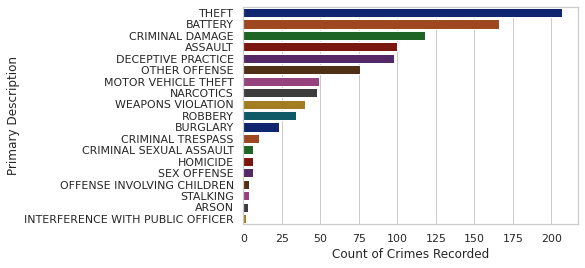

In [54]:
visualize_crime_types(df_crime_types)

In [55]:
sc.stop()